In [1]:
import scipy.io
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import pysindy as ps
import matplotlib.pyplot as plt

In [2]:
def extract_matrix_from_octave_mat_file(file_path, matrix_name):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].startswith('# name:') and lines[i].split()[2] == matrix_name:
                var_type = lines[i + 1].split()[2]
                if var_type == 'matrix':
                    rows = int(lines[i + 2].split()[2])
                    cols = int(lines[i + 3].split()[2])
                    matrix = []
                    for r in range(rows):
                        row_data = [float(x) for x in lines[i + 4 + r].split()]
                        matrix.append(row_data)
                    return pd.DataFrame(matrix)
            i += 1 
    return None

file_path = "./datasets/RP_data_01.mat"
matrix_name = "xh"
df = extract_matrix_from_octave_mat_file(file_path, matrix_name)
df


,0,1
0,1.000000,0.000000
1,0.999945,-0.010986
2,0.999780,-0.021956
3,0.999506,-0.032907
4,0.999122,-0.043836
...,...,...
29996,0.888144,0.705358
29997,0.895214,0.708167
29998,0.902306,0.709950
29999,0.909412,0.710814


In [3]:
df_x = pd.DataFrame(df)
df_x

,0,1
0,1.000000,0.000000
1,0.999945,-0.010986
2,0.999780,-0.021956
3,0.999506,-0.032907
4,0.999122,-0.043836
...,...,...
29996,0.888144,0.705358
29997,0.895214,0.708167
29998,0.902306,0.709950
29999,0.909412,0.710814


In [4]:
initial_conditions = [1, 0]
t_span = [0, 300]
dt = 0.01
t_values = np.arange(t_span[0], t_span[1], dt)

optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(optimizer=optimizer)
model.fit(df_x[[0, 1]], t=dt)
model.print()

x0 = initial_conditions
predicted = model.simulate(x0, t_values)

predicted_df = pd.DataFrame(predicted, columns=['x1_pred', 'x2_pred'])
predicted_df['Time'] = t_values

(x0)' = 1.000 x1
(x1)' = 5.340 1 + -8.043 x0 + -0.778 x1 + 2.751 x0^2 + 0.745 x0 x1 + -0.191 x1^2


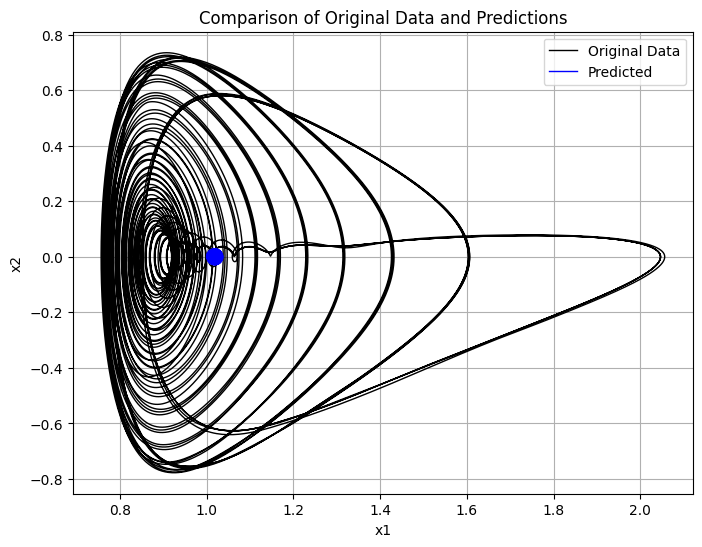

In [5]:
plt.figure(figsize=(8, 6))

plt.plot(df_x[0], df_x[1], 'k', label='Original Data', linewidth=1)

plt.plot(predicted_df['x1_pred'], predicted_df['x2_pred'], 'b', label='Predicted', linewidth=1)


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Comparison of Original Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
library_functions = [lambda x: np.sin(x)]
library_function_names = [lambda x: f"sin({x})"]

library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
combined_library = ps.PolynomialLibrary() + library

model = ps.SINDy(feature_library=combined_library, optimizer=optimizer)

model.fit(df_x[[0, 1]], t=dt)
model.print()

x0 = initial_conditions
predicted_with_sin = model.simulate(x0, t_values)

predicted_df_with_sin = pd.DataFrame(predicted_with_sin, columns=['x1_pred', 'x2_pred'])
predicted_df_with_sin['Time'] = t_values

(x0)' = 1.000 x1
(x1)' = 75.255 1 + -591.177 x0 + -4.028 x1 + 188.352 x0^2 + 0.603 x0 x1 + -0.249 x1^2 + 388.798 sin(x0) + 3.552 sin(x1)


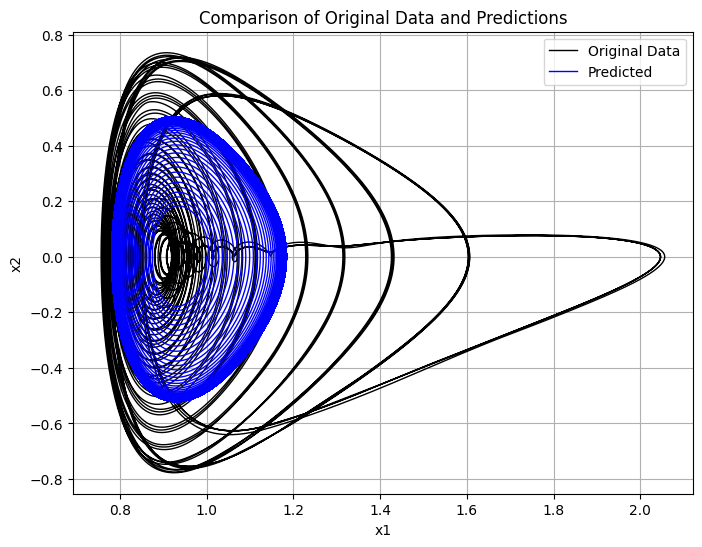

In [7]:
plt.figure(figsize=(8, 6))

plt.plot(df_x[0], df_x[1], 'k', label='Original Data', linewidth=1)

plt.plot(predicted_df_with_sin['x1_pred'], predicted_df_with_sin['x2_pred'], 'b', label='Predicted', linewidth=1)


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Comparison of Original Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
library_functions = [lambda x: np.sin(x), lambda x: np.cos(x), lambda x: np.tan(x)]
library_function_names = [lambda x: f"sin({x})", lambda x: f"cos({x})", lambda x: f"tan({x})"]

library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
combined_library = ps.PolynomialLibrary() + library

model = ps.SINDy(feature_library=combined_library, optimizer=optimizer)

model.fit(df_x[[0, 1]], t=dt)
model.print()

x0 = initial_conditions
predicted_with_sin = model.simulate(x0, t_values)

predicted_df_with_sin = pd.DataFrame(predicted_with_sin, columns=['x1_pred', 'x2_pred'])
predicted_df_with_sin['Time'] = t_values

(x0)' = 1.215 x1 + -0.153 sin(x1) + -0.062 tan(x1)
(x1)' = -109.341 1 + -935.109 x0 + -80.895 x1 + 314.143 x0^2 + 0.401 x0 x1 + 77.305 x1^2 + 643.004 sin(x0) + 58.235 sin(x1) + 52.876 cos(x0) + 160.246 cos(x1) + 22.460 tan(x1)


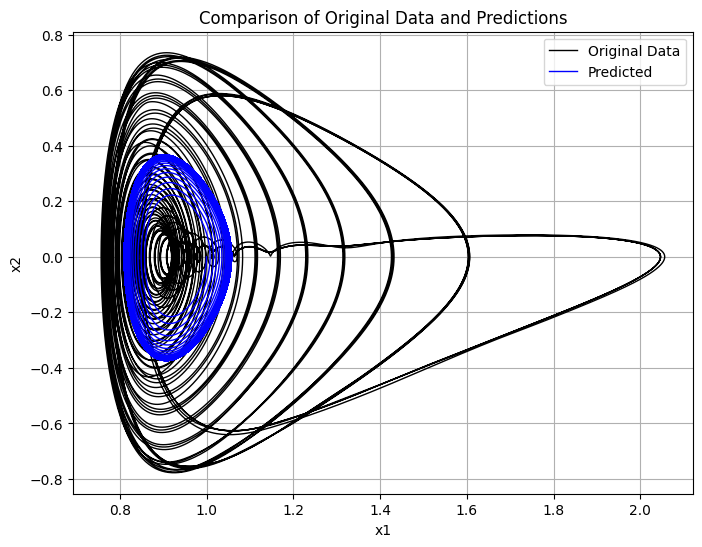

In [9]:
plt.figure(figsize=(8, 6))

plt.plot(df_x[0], df_x[1], 'k', label='Original Data', linewidth=1)

plt.plot(predicted_df_with_sin['x1_pred'], predicted_df_with_sin['x2_pred'], 'b', label='Predicted', linewidth=1)


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Comparison of Original Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.linear_model import Lasso
optimizer_lasso = Lasso(alpha=0.005)
model = ps.SINDy(optimizer=optimizer_lasso)
model.fit(df_x[[0, 1]], t=dt)
model.print()

x0 = initial_conditions
predicted_without_sin_with_lasso = model.simulate(x0, t_values)

predicted_df_without_sin_with_lasso = pd.DataFrame(predicted_without_sin_with_lasso, columns=['x1_pred', 'x2_pred'])
predicted_df_without_sin_with_lasso['Time'] = t_values


(x0)' = 0.999 x1 + 0.001 x0 x1
(x1)' = -8.040 x0 + 2.754 x0^2 + 2.834


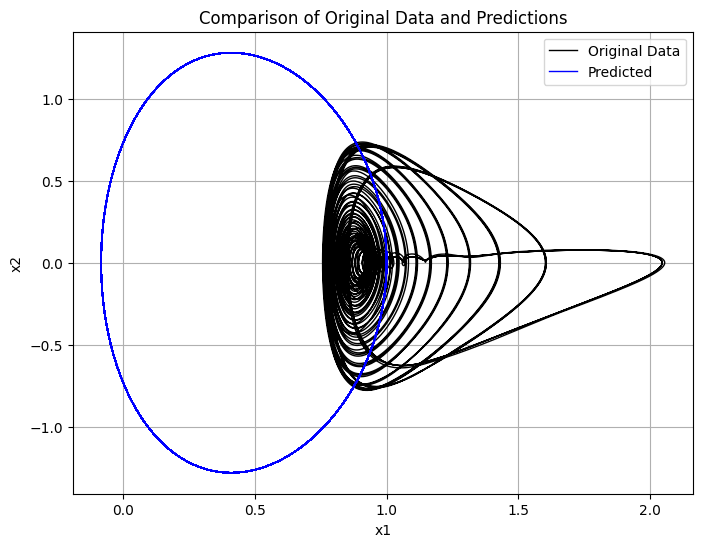

In [11]:
plt.figure(figsize=(8, 6))

plt.plot(df_x[0], df_x[1], 'k', label='Original Data', linewidth=1)

plt.plot(predicted_df_without_sin_with_lasso['x1_pred'], predicted_df_without_sin_with_lasso['x2_pred'], 'b', label='Predicted', linewidth=1)


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Comparison of Original Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
model = ps.SINDy(feature_library=combined_library, optimizer=optimizer_lasso)

model.fit(df_x[[0, 1]], t=dt)
model.print()

x0 = initial_conditions
predicted_with_sin_with_lasso = model.simulate(x0, t_values)

predicted_df_with_sin_with_lasso = pd.DataFrame(predicted_with_sin_with_lasso, columns=['x1_pred', 'x2_pred'])
predicted_df_with_sin_with_lasso['Time'] = t_values

(x0)' = 0.139 x0 x1 + 0.769 tan(x1) + 0.001
(x1)' = 0.187 x0^2 + -5.224 sin(x0) + 3.210


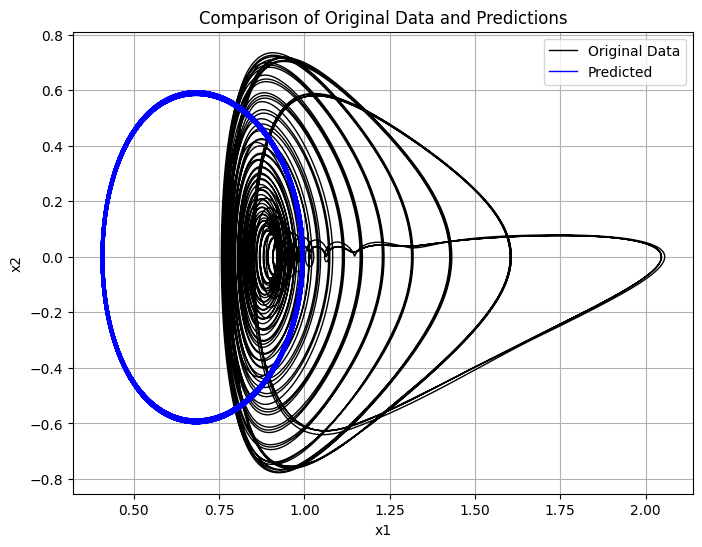

In [13]:
plt.figure(figsize=(8, 6))

plt.plot(df_x[0], df_x[1], 'k', label='Original Data', linewidth=1)

plt.plot(predicted_df_with_sin_with_lasso['x1_pred'], predicted_df_with_sin_with_lasso['x2_pred'], 'b', label='Predicted', linewidth=1)


plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Comparison of Original Data and Predictions')
plt.legend()
plt.grid(True)
plt.show()